<a href="https://colab.research.google.com/github/Moinkhan15-03-2004/2DArray1/blob/main/Employee_Attrition_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Load data (change path to your downloaded CSV)
df = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition (2).csv')
print(df.shape)
df.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
print(df['Attrition'].value_counts())
print(df['Attrition'].value_counts(normalize=True))

Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print('Categorical:', cat_cols)
print('Numerical:', num_cols)

Categorical: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
Numerical: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


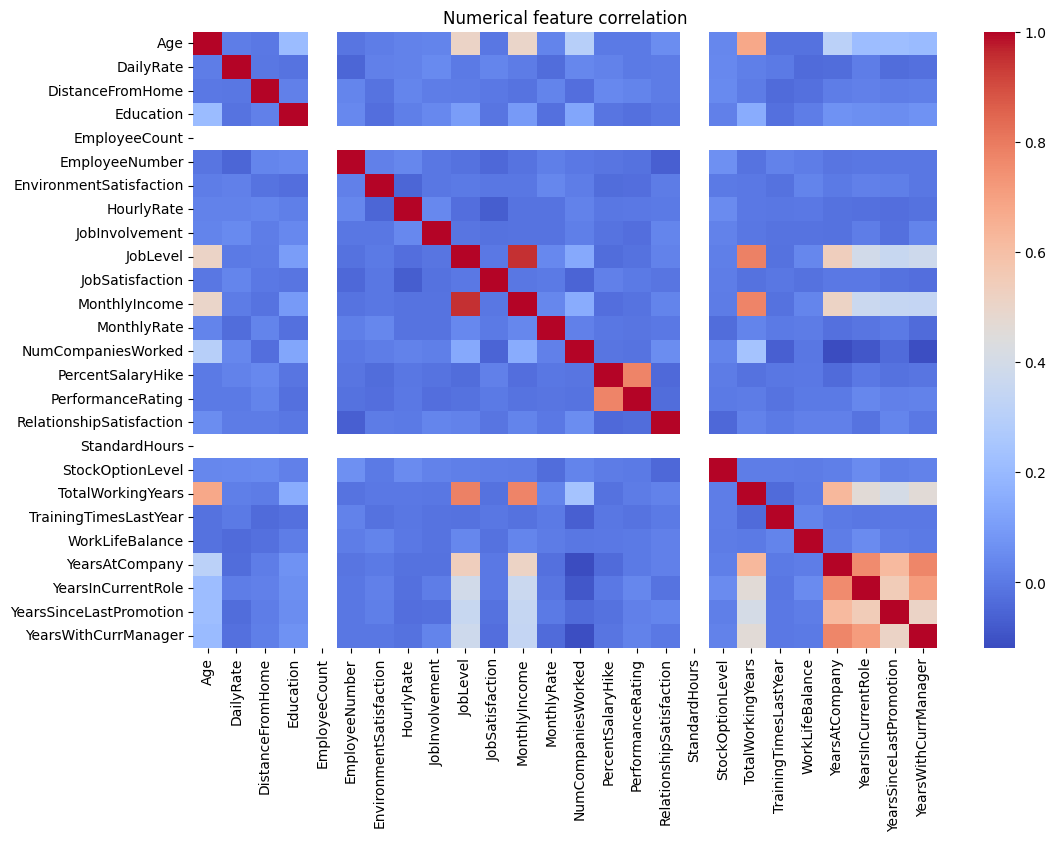

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Numerical feature correlation')
plt.show()

In [ ]:
# Example preprocessing pipeline
from sklearn.preprocessing import OrdinalEncoder

# small utility: choose columns
num_features = ['Age','MonthlyIncome','TotalWorkingYears','YearsAtCompany','DistanceFromHome']
cat_features = [c for c in cat_cols if c != 'Attrition']  # drop target

# Transformers
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', ))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])


In [ ]:
# Prepare X, y
X = df.drop(columns=['Attrition'])
y = df['Attrition'].map({'Yes':1,'No':0})

# Train-test split (stratify to keep class ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline with preprocessor + model
pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
y_proba = pipe_lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.86      0.98      0.91       247
           1       0.57      0.17      0.26        47

    accuracy                           0.85       294
   macro avg       0.72      0.57      0.59       294
weighted avg       0.81      0.85      0.81       294

ROC AUC: 0.7424412094064949


In [ ]:
rf = RandomForestClassifier(random_state=42)

pipe_rf = Pipeline(steps=[('pre', preprocessor), ('rf', rf)])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [6, 10, None],
    'rf__min_samples_split': [2, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe_rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
best = gs.best_estimator_
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       247
           1       0.52      0.23      0.32        47

    accuracy                           0.84       294
   macro avg       0.70      0.60      0.62       294
weighted avg       0.81      0.84      0.82       294

ROC AUC: 0.7728486519080024


MonthlyIncome                       0.152302
Age                                 0.125307
TotalWorkingYears                   0.113463
YearsAtCompany                      0.096442
DistanceFromHome                    0.089727
OverTime_No                         0.043010
OverTime_Yes                        0.039811
MaritalStatus_Single                0.032387
JobRole_Laboratory Technician       0.025241
BusinessTravel_Travel_Frequently    0.023476
EducationField_Medical              0.019603
Gender_Male                         0.018809
MaritalStatus_Married               0.018763
Gender_Female                       0.018727
EducationField_Life Sciences        0.017610
JobRole_Research Scientist          0.016223
BusinessTravel_Travel_Rarely        0.015089
MaritalStatus_Divorced              0.013789
JobRole_Sales Representative        0.013646
JobRole_Sales Executive             0.013001
dtype: float64


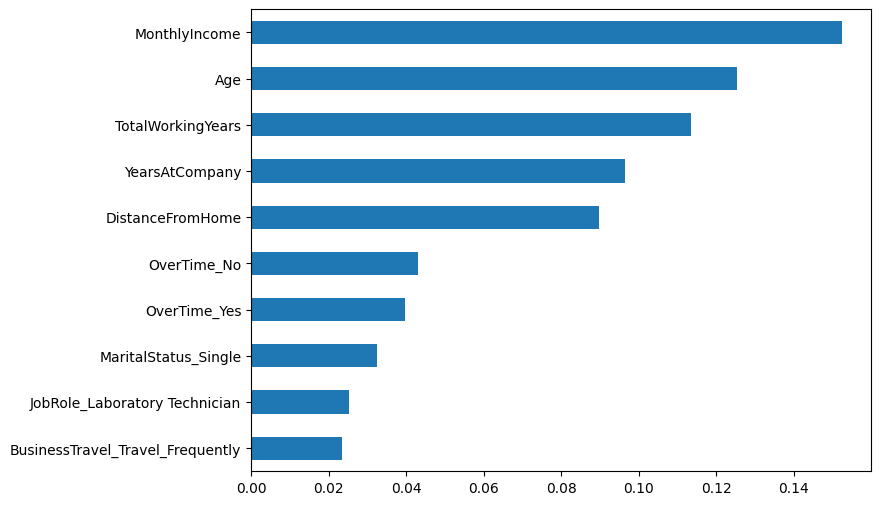

In [ ]:
# Feature importance (from RandomForest)
importances = best.named_steps['rf'].feature_importances_

# To get feature names after ColumnTransformer
# get feature names from onehot encoder
ohe = best.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
ohe_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(ohe_names)

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(20))
feat_imp.head(10).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import shap
explainer = shap.TreeExplainer(best.named_steps['rf'])
X_test_trans = best.named_steps['pre'].transform(X_test)  # numpy array
shap_values = explainer.shap_values(X_test_trans)
shap.summary_plot(shap_values[1], X_test_trans, feature_names=feature_names)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
import shap
explainer = shap.TreeExplainer(best.named_steps['rf'])
X_test_trans = best.named_steps['pre'].transform(X_test)  # numpy array
shap_values = explainer.shap_values(X_test_trans)
shap.summary_plot(shap_values[1], X_test_trans, feature_names=feature_names)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.